# Frequency domain analysis
Frequency domain analysis of experimental and synthetic images of ferritin rings. Data and plots generated in this notebook are used in Figure 9.

In [ ]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tem_staining.spectral_analysis import power_spectrum, radially_averaged_spectrum
import seaborn as sns
from imageio.v3 import immeta
import pandas as pd


plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.bf"] = "Arial:bold"

inch_size = 2.54

# Colors and labels
colors = {
    "SyntheticData": "#017371",
    "UA": "#BC2F27",
    "Lc": "#DFB044",
    "UL": "#CEB1D2",
    "UAR": "#6C3880",
    "UAZ": "#22274B",
    "PTA": "#323F8E",
    "Stain77": "#323F8E",
    "NanoW": "#69BDDE",
    "NanoV": "#9BB4C3",
}

labels = {
    "SyntheticData": "Synthetic data",
    "UA": "UA",
    "Lc": "Lc",
    "UL": "UL",
    "UAR": "UAR",
    "UAZ": "UAZ",
    "PTA": "PTA",
    "Stain77": "STAIN 77",
    "NanoW": "Nano-W",
    "NanoV": "NanoV",
}

In [2]:
# Crop raw data to remove databar
for image_path in Path("Data/Raw/").rglob("*/*.tif"):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)[:920, 0:920]
    assert immeta(image_path)["magnification"] == 140000

    results_path = Path("Data/Processed") / image_path.parent.name
    results_path.mkdir(parents=True, exist_ok=True)

    image_save_path = results_path / f"{image_path.stem}_cropped.tif"
    cv2.imwrite(image_save_path, image)

# Calculate image power spectra
for image_path in Path("Data/Processed/").rglob("*/*.tif"):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    f_magnitude = power_spectrum(image)
    raps = radially_averaged_spectrum(image)

    # Apply colormap and save power spectrum
    f_magnitude_normalized = (f_magnitude - raps[:460].min()) / (
        f_magnitude.max() - raps[:460].min()
    )
    f_magnitude_color = plt.cm.gray(f_magnitude_normalized)[:, :, :3]
    f_magnitude_color = (f_magnitude_color * 255).astype(np.uint8)

    image_name = image_path.stem
    
    cv2.imwrite(
        image_path.parent / f"{image_name}_power_spectrum.png",
        cv2.cvtColor(f_magnitude_color, cv2.COLOR_RGB2GRAY),
    )

    # Plot and save radially averaged power spectrum
    pd.DataFrame(raps, columns=["intensity"]).to_csv(
        image_path.parent / f"{image_name}_raps.csv", index=True, index_label="frequency"
    )

In [3]:
# Calculate radial power spectrum averages by stain type
for directory in Path("Data/Processed").glob("*/"):
    stain_type = directory.name
    raps = []
    for raps_path in directory.rglob("*_raps.csv"):
        raps.append(pd.read_csv(raps_path, index_col=0))

    raps = pd.concat(raps)
    raps = raps.groupby("frequency").mean()

    results_path = Path("Data/Results") / stain_type
    results_path.mkdir(parents=True, exist_ok=True)

    raps.to_csv(
        results_path / f"{stain_type}_raps_mean.csv", index=True, index_label="frequency"
    )

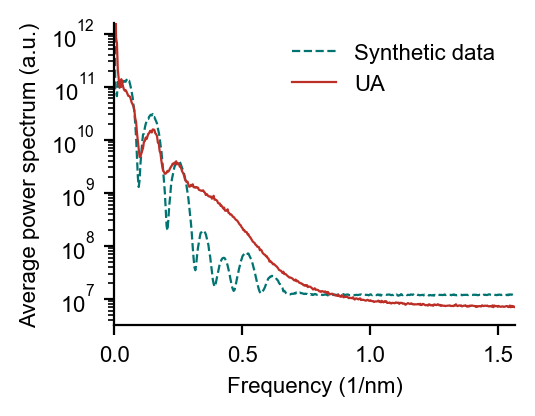

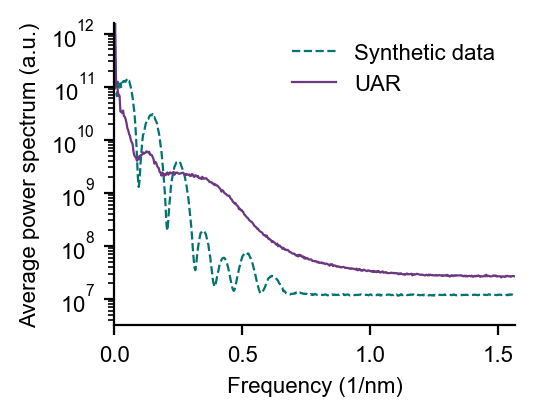

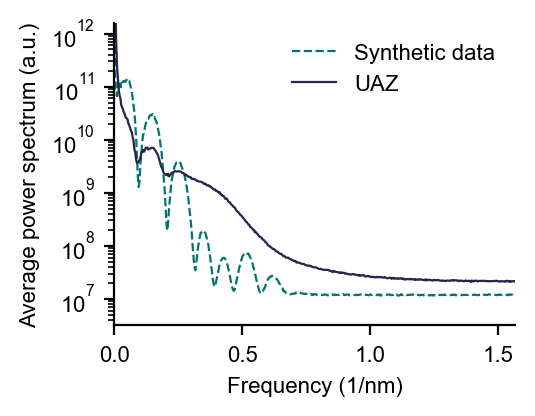

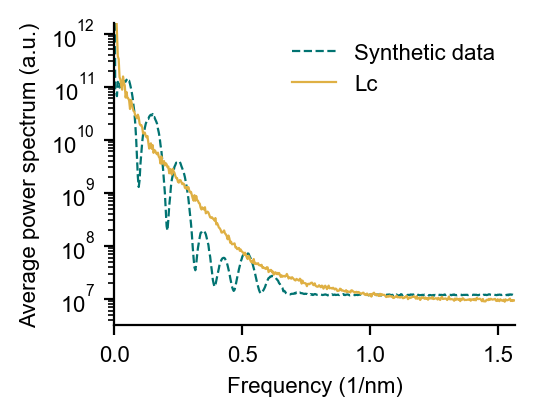

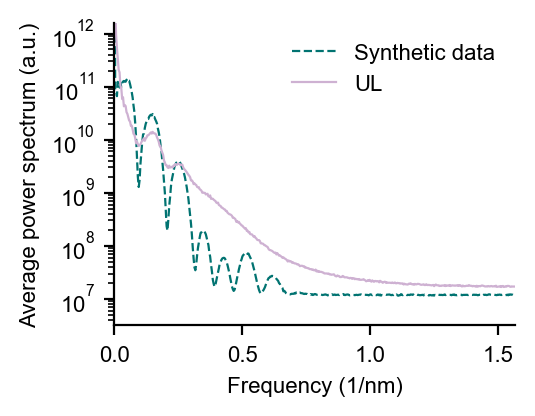

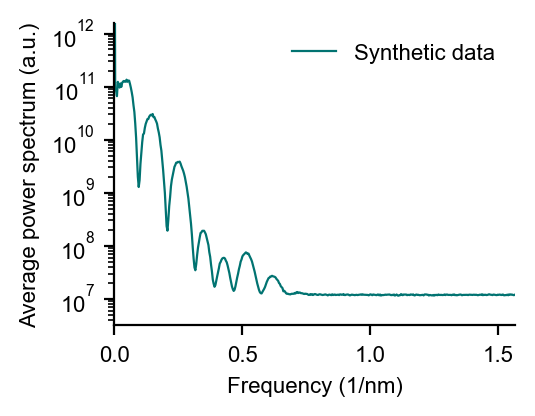

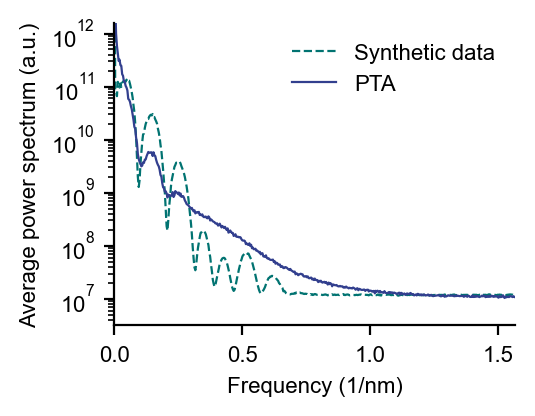

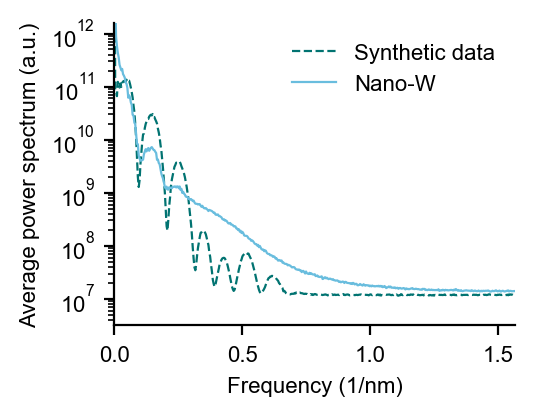

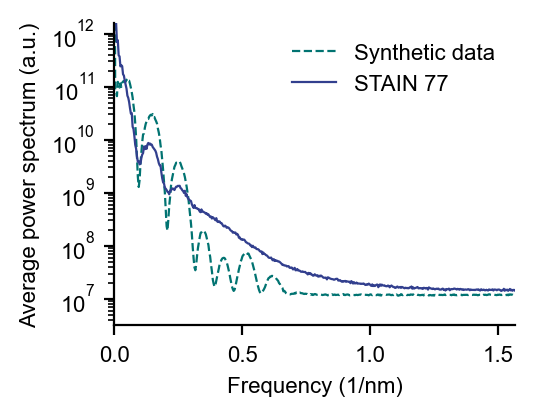

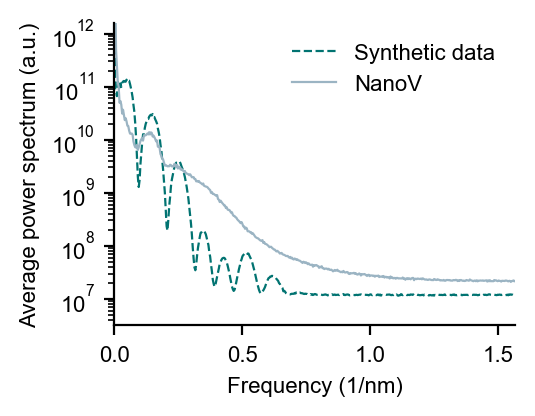

In [4]:
# Plot radial power spectrum averages by stain type
linewidth = 0.8

raps_synth = pd.read_csv(
    "Data/Results/SyntheticData/SyntheticData_raps_mean.csv", index_col=0
).to_numpy()[:, 0]
raps_ua = pd.read_csv("Data/Results/UA/UA_raps_mean.csv", index_col=0).to_numpy()[:, 0]

# Convert frequency units to nm^-1
metadata = immeta("Data/Raw/UA/UA-01.tif")
pixel_size = metadata["pixelsizex"] * 1e9
nyquist = 1 / (2 * pixel_size)
frequency = np.arange(len(raps_ua)) / (920 / 2) * nyquist

for raps_path in Path("Data/Results/").rglob("*/*_raps_mean.csv"):
    raps = pd.read_csv(raps_path, index_col=0).to_numpy()[:, 0]

    stain_type = raps_path.parent.name

    fig, ax = plt.subplots(
        figsize=(6.5 / inch_size, 4.995 / inch_size), dpi=200, layout="constrained"
    )

    if not stain_type == "SyntheticData":
        ax.plot(
            frequency,
            10**raps_synth,
            lw=linewidth,
            label=labels["SyntheticData"],
            color=colors["SyntheticData"],
            ls="--",
        )
    ax.plot(
        frequency,
        10**raps,
        lw=linewidth,
        label=labels[stain_type],
        color=colors[stain_type],
    )
    ax.set(
        xlabel="Frequency (1/nm)",
        ylabel="Average power spectrum (a.u.)",
        xlim=(0, nyquist),
        ylim=(10**6.5, 10**12.2),
    )
    ax.set_yscale("log")
    ax.legend(frameon=False)
    sns.despine()

    fig.savefig(raps_path.parent / f"{stain_type}_raps_mean_plot.png", dpi=300)
plt.show()